<a href="https://colab.research.google.com/github/abaskon/Thesis/blob/main/GPR_DBI_VAR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Import Libraries

In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import arch
from arch import arch_model

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



#####Read data and standardise them

In [ ]:
dbi1 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI1985-2004.csv")
dbi2 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI2004-today.csv")

dbi1['Price'] = dbi1['Price'].str.replace(',', '').astype(float)
dbi2['Price'] = dbi2['Price'].str.replace(',', '').astype(float)

In [ ]:
dbi1['Date'] = pd.to_datetime(dbi1['Date'], format='%m/%d/%Y')
dbi2['Date'] = pd.to_datetime(dbi2['Date'], format='%m/%d/%Y')

In [ ]:
dbi1.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2004-11-22,5442.0,"5,442.00","5,442.00","5,442.00",NaN,0.91%
1,2004-11-19,5393.0,"5,393.00","5,393.00","5,393.00",NaN,1.09%
2,2004-11-18,5335.0,"5,335.00","5,335.00","5,335.00",NaN,1.35%
3,2004-11-17,5264.0,"5,264.00","5,264.00","5,264.00",NaN,1.41%
4,2004-11-16,5191.0,"5,191.00","5,191.00","5,191.00",NaN,0.76%


In [ ]:
# concatenate the two tables based on the 'date' column
DBI = pd.concat([dbi1, dbi2]).drop_duplicates(subset='Date')

DBI = DBI.sort_values(by='Date', ascending=True)
DBI = DBI.reset_index(drop=True)

In [ ]:
DBI

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%
3,1985-01-10,979.5,979.50,979.50,979.50,NaN,-1.51%
4,1985-01-11,980.5,980.50,980.50,980.50,NaN,0.10%
...,...,...,...,...,...,...,...
9595,2023-04-28,1576.0,"1,576.00","1,576.00","1,576.00",NaN,-0.32%
9596,2023-05-02,1552.0,"1,552.00","1,552.00","1,552.00",NaN,-1.52%
9597,2023-05-03,1558.0,"1,558.00","1,558.00","1,558.00",NaN,0.39%
9598,2023-05-04,1545.0,"1,545.00","1,545.00","1,545.00",NaN,-0.83%


In [ ]:
GPR = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_daily_recent.csv")
GPRE = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_export.csv")
GPR['GPRD'] = GPR['GPRD'].str.replace(',', '').astype(float)


In [ ]:
GPR

,DAY,N10D,GPRD,GPRD_ACT,GPRD_THREAT,date,GPRD_MA30,GPRD_MA7,event,var_name,var_label
0,19850101,216,230.04,275.20,153.03,01-01-1985,230.04,230.04,NaN,DAY,DAY
1,19850102,315,115.68,146.77,87.44,02-01-1985,172.86,172.86,NaN,N10D,"Number of articles (10 recent newspapers, 1985-)"
2,19850103,374,97.43,158.94,29.46,03-01-1985,147.71,147.71,NaN,GPRD,Daily GPR (Index: 1985:2019=100)
3,19850104,421,157.37,156.88,157.03,04-01-1985,150.13,150.13,NaN,GPRD_ACT,Daily GPR Acts (Index: 1985:2019=100)
4,19850105,285,81.36,92.70,77.32,05-01-1985,136.37,136.37,NaN,GPRD_THREAT,Daily GPR Threats (Index: 1985:2019=100)
...,...,...,...,...,...,...,...,...,...,...,...
13988,20230420,470,98.67,126.47,70.33,20-04-2023,93.04,98.11,NaN,NaN,NaN
13989,20230421,453,117.00,102.06,121.61,21-04-2023,92.90,98.72,NaN,NaN,NaN
13990,20230422,522,63.46,101.22,31.66,22-04-2023,91.56,95.33,NaN,NaN,NaN
13991,20230423,355,55.99,93.02,31.04,23-04-2023,90.75,97.36,NaN,NaN,NaN


In [ ]:
GPR['date'] = pd.to_datetime(GPR['date'], format='%d-%m-%Y')
GPR = GPR.rename(columns={'date': 'Date'})

In [ ]:
GPR = GPR[['Date', 'GPRD', 'event']]

In [ ]:
GPR.head(4)

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN
3,1985-01-04,157.37,NaN


In [ ]:
GPRE['month'] = pd.to_datetime(GPRE['month'], format='%d-%m-%Y')
GPRE = GPRE.rename(columns={'month': 'Date'})

In [ ]:
GPRE.head(6)

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
0,1900-01-01,NaN,NaN,NaN,87.93,64.72,110.45,NaN,NaN,3.17,...,0.08,0.00,0.04,0.00,0.0,2.72,0.05,1.15,month,Date (year/month)
1,1900-02-01,NaN,NaN,NaN,86.57,71.94,96.25,NaN,NaN,3.12,...,0.08,0.00,0.13,0.00,0.0,2.73,0.03,1.14,GPR,Recent GPR (Index: 1985:2019=100)
2,1900-03-01,NaN,NaN,NaN,72.14,57.48,84.50,NaN,NaN,2.60,...,0.12,0.00,0.18,0.00,0.0,2.15,0.03,0.86,GPRT,Recent GPR Threats (Index: 1985:2019=100)
3,1900-04-01,NaN,NaN,NaN,54.42,37.33,65.86,NaN,NaN,1.96,...,0.04,0.00,0.07,0.00,0.0,1.78,0.00,0.64,GPRA,Recent GPR Acts (Index: 1985:2019=100)
4,1900-05-01,NaN,NaN,NaN,64.41,48.20,74.37,NaN,NaN,2.32,...,0.16,0.00,0.08,0.00,0.0,1.97,0.01,0.79,GPRH,Historical GPR (Index: 1900:2019=100)
5,1900-06-01,NaN,NaN,NaN,83.61,70.01,93.98,NaN,NaN,3.02,...,0.08,0.01,0.11,0.03,0.0,2.73,0.03,0.67,GPRHT,Historical GPR Threats (Index: 1900:2019=100)


In [ ]:
GPRE[GPRE["Date"] == "1985-02-01"]

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
1021,1985-02-01,117.1,126.44,96.6,99.55,127.21,75.1,3.51,10819.0,3.59,...,0.2,0.04,0.03,0.0,0.01,3.34,0.07,0.11,NaN,NaN


In [ ]:
GPR[GPR["Date"] == "1985-02-01"]

,Date,GPRD,event
31,1985-02-01,106.61,NaN


In [ ]:
GPRE = GPRE[['Date', 'GPR','GPRC_ARG', 'GPRC_AUS', 'GPRC_BEL', 'GPRC_BRA', 'GPRC_CAN', 'GPRC_CHE', 'GPRC_CHL', 'GPRC_CHN', 'GPRC_COL', 'GPRC_DEU', 'GPRC_DNK', 'GPRC_EGY', 'GPRC_ESP', 'GPRC_FIN', 'GPRC_FRA', 'GPRC_GBR', 'GPRC_HKG', 'GPRC_HUN', 'GPRC_IDN', 'GPRC_IND', 'GPRC_ISR', 'GPRC_ITA', 'GPRC_JPN', 'GPRC_KOR', 'GPRC_MEX', 'GPRC_MYS', 'GPRC_NLD', 'GPRC_NOR', 'GPRC_PER', 'GPRC_PHL', 'GPRC_POL', 'GPRC_PRT', 'GPRC_RUS', 'GPRC_SAU', 'GPRC_SWE', 'GPRC_THA', 'GPRC_TUN', 'GPRC_TUR', 'GPRC_TWN', 'GPRC_UKR', 'GPRC_USA', 'GPRC_VEN', 'GPRC_ZAF']]

In [ ]:
GPRE = GPRE[GPRE['Date'] >= '1985-02-01']

In [ ]:
GPRE

,Date,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
1021,1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1022,1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15
1023,1985-04-01,87.93,0.03,0.07,0.08,0.03,0.34,0.02,0.05,0.20,...,0.10,0.03,0.05,0.00,0.12,0.02,0.03,2.00,0.12,0.14
1024,1985-05-01,103.26,0.07,0.04,0.10,0.07,0.43,0.06,0.05,0.13,...,0.09,0.08,0.06,0.02,0.02,0.01,0.01,2.39,0.11,0.16
1025,1985-06-01,148.78,0.02,0.03,0.09,0.04,0.50,0.23,0.04,0.12,...,0.09,0.07,0.02,0.05,0.07,0.02,0.01,3.81,0.05,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,2022-11-01,118.74,0.03,0.12,0.28,0.13,0.28,0.05,0.01,1.15,...,0.17,0.14,0.04,0.03,0.49,0.40,2.48,2.75,0.03,0.08
1475,2022-12-01,113.86,0.03,0.20,0.19,0.06,0.22,0.06,0.01,0.89,...,0.17,0.11,0.03,0.01,0.26,0.30,2.26,2.60,0.06,0.04
1476,2023-01-01,105.63,0.03,0.13,0.21,0.12,0.29,0.17,0.02,0.70,...,0.05,0.17,0.03,0.01,0.22,0.17,1.99,2.42,0.03,0.04
1477,2023-02-01,127.34,0.01,0.16,0.34,0.06,0.42,0.05,0.04,1.58,...,0.15,0.15,0.02,0.01,0.51,0.37,2.12,3.15,0.02,0.10


#####Visualisations

In [ ]:
def plotgraph(df, x, y):
    df[y] = pd.to_numeric(df[y])
    df.plot(x=x, y=y, figsize=(20, 4))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('USD per Metric Tonne')
    plt.show()


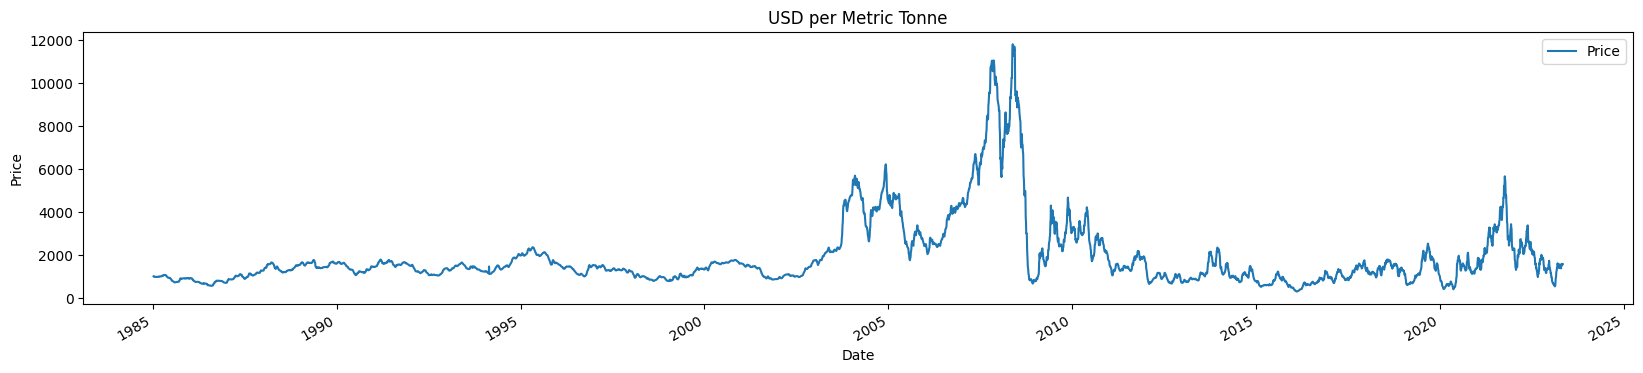

In [ ]:
plotgraph(DBI,'Date','Price')

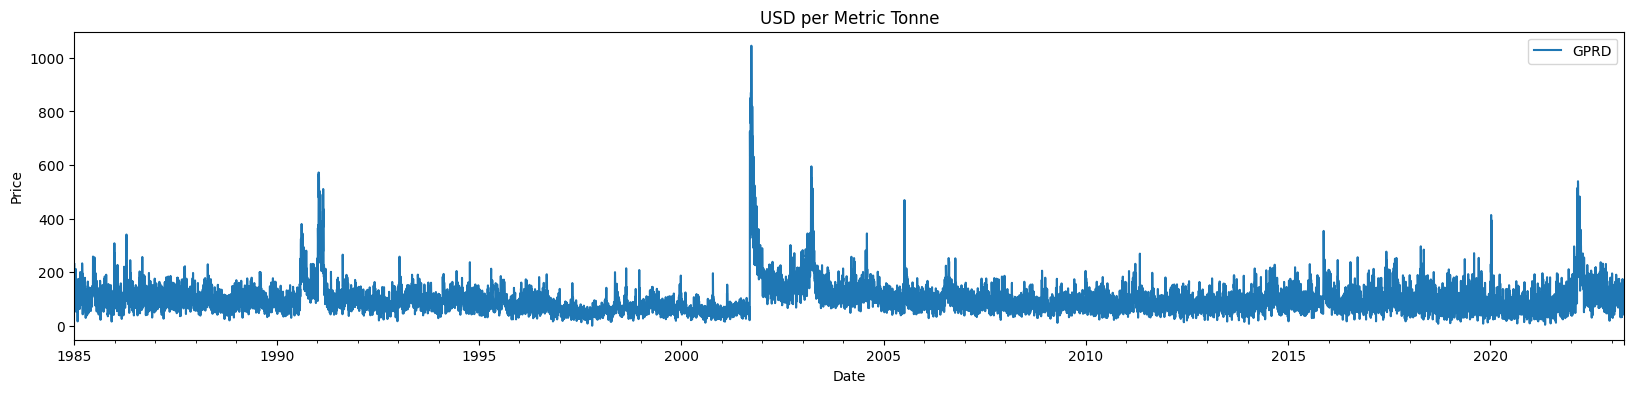

In [ ]:
plotgraph(GPR,'Date','GPRD')

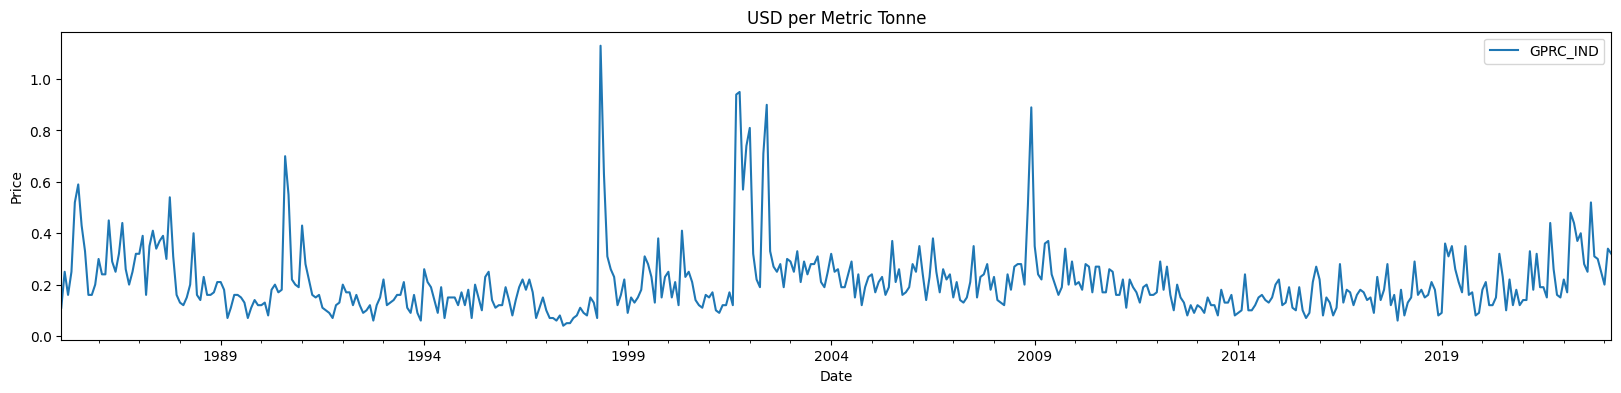

In [ ]:
plotgraph(GPRE,'Date','GPRC_IND')

In [ ]:
# Plotly line plot
fig = go.Figure(data=[go.Scatter(x=DBI['Date'], y=DBI['Price'])])
fig.show()


#####Others

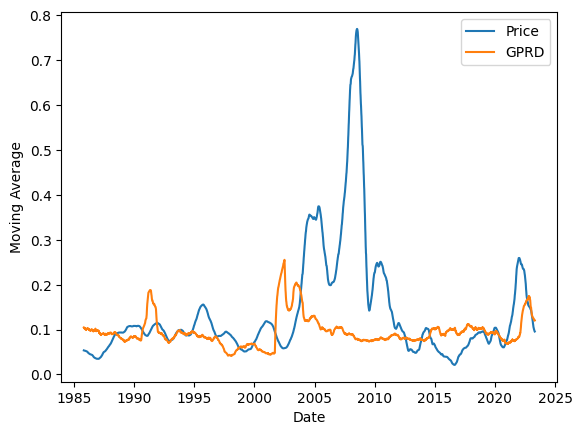

In [ ]:
df.set_index('Date', inplace=True)

# calculate the rolling mean of Price and GPRD with a window of 30 days
rolling_mean = df.rolling(window=200).mean()

# plot the rolling mean of Price and GPRD with Date as x-axis
plt.plot(rolling_mean['Price'], label='Price')
plt.plot(rolling_mean['GPRD'], label='GPRD')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.legend()
plt.show()

In [ ]:
rolling_mean = rolling_mean.fillna(0)